In [6]:
import os
import math
import pickle
import struct
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def decode_labels(file):
    with open(file, 'rb') as f:
        binary_data = f.read()
    _, num_items = struct.unpack_from('>II', binary_data, 0)
    labels       = struct.unpack_from('B'*num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int)

def decode_images(file):
    with open(file, 'rb') as f:
        binary_data = f.read()
    _,num_images, rows, cols = struct.unpack_from('>IIII', binary_data, 0)
    images                   = struct.unpack_from('B'*(num_images*rows*cols), binary_data, 16)
    return np.array(images).reshape(-1, rows*cols)

def one_hot(y, num_classes):
    rows   = y.shape[0]
    output = np.zeros((rows, num_classes), np.uint8)
    for i in range(rows):
        output[i, y[i]] = 1 # y的值是几，就把1更新到第几列，行号取决于第几个出现
    return output

def norm_image(image):  # 将图像进行标准化
    return (image / 255 - 0.5).astype(np.float32)

y = np.array([1,3,6,7,2,5,8])[...,None]
one_hot(y, 10)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=uint8)

In [8]:
class DataSet:
    def __init__(self, image_file, label_file, num_classes=10):
        self.images      = decode_images(image_file)
        self.labels      = decode_labels(label_file)
        self.onehot      = one_hot(self.labels, num_classes)
        self.num_classes = num_classes
    
    def __getitem__(self, index):
        '''重载索引器'''
        return self.images[index], self.labels[index], self.onehot[index]
    
    def __len__(self):
        return len(self.images)
    
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset    = dataset
        self.shuffle    = shuffle
        self.count      = len(dataset)
        self.batch_size =  batch_size
    
    def __iter__(self):
        return DataLoaderIterator(self)
    
    def __len__(self):
        '''batch count'''
        return math.ceil(len(self.dataset) / self.batch_size)
    
class DataLoaderIterator:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cursor     = 0
        self.indexs     = list(range(self.dataloader.count))
        if self.dataloader.shuffle:
            np.random.shuffle(self.indexs)
        
    def __next__(self):
        if self.cursor >= self.dataloader.count:
            raise StopIteration()
        
        output    = []
        one_batch = min(self.dataloader.batch_size, self.dataloader.count - self.cursor)
        for _ in range(one_batch):
            index = self.indexs[self.cursor]
            data  = self.dataloader.dataset[index]
            output.append(data)
            self.cursor += 1
#         output = np.split(output, [1,2], 1)# list(range(1, len(data)-1)), 1)
        output = list(zip(*output))
        for i in range(len(output)):
            output[i] = np.vstack(output[i])
        return output

In [9]:
# 测试DataLoader
dataset = DataSet("../stage_1/data/mnist/t10k-images-idx3-ubyte", "../stage_1/data/mnist/t10k-labels-idx1-ubyte")
loader = DataLoader(dataset, 256)
print('len(loader) = ', len(loader))
for ibatch, (images, labels, targets) in enumerate(loader):
    print(ibatch, images.shape, labels.shape, targets.shape)

len(loader) =  40
0 (256, 784) (256, 1) (256, 10)
1 (256, 784) (256, 1) (256, 10)
2 (256, 784) (256, 1) (256, 10)
3 (256, 784) (256, 1) (256, 10)
4 (256, 784) (256, 1) (256, 10)
5 (256, 784) (256, 1) (256, 10)
6 (256, 784) (256, 1) (256, 10)
7 (256, 784) (256, 1) (256, 10)
8 (256, 784) (256, 1) (256, 10)
9 (256, 784) (256, 1) (256, 10)
10 (256, 784) (256, 1) (256, 10)
11 (256, 784) (256, 1) (256, 10)
12 (256, 784) (256, 1) (256, 10)
13 (256, 784) (256, 1) (256, 10)
14 (256, 784) (256, 1) (256, 10)
15 (256, 784) (256, 1) (256, 10)
16 (256, 784) (256, 1) (256, 10)
17 (256, 784) (256, 1) (256, 10)
18 (256, 784) (256, 1) (256, 10)
19 (256, 784) (256, 1) (256, 10)
20 (256, 784) (256, 1) (256, 10)
21 (256, 784) (256, 1) (256, 10)
22 (256, 784) (256, 1) (256, 10)
23 (256, 784) (256, 1) (256, 10)
24 (256, 784) (256, 1) (256, 10)
25 (256, 784) (256, 1) (256, 10)
26 (256, 784) (256, 1) (256, 10)
27 (256, 784) (256, 1) (256, 10)
28 (256, 784) (256, 1) (256, 10)
29 (256, 784) (256, 1) (256, 10)
30

In [ ]:
def gemm_conv(tensor, kernel):
    _, kh, kw = kernel.shape
    n, c, h, w = tensor.shape
    s = (w - kw + 1) * (h - kh + 1)
    column = np.zeros((n, kh * kw * c, s))
    col_kernel = kernel.reshape(1, -1)
    half_kx = kw // 2
    half_ky = kh // 2
    ksize = kw * kh
    
    for m in range(n):
        for ic in range(c):
            col_x = 0
            for iy in range(half_ky, h - half_ky):
                for ix in range(half_kx, w - half_kx):
                    for iky in range(kh):
                        for ikx in range(kw):
                            pixel_value = tensor[m, ic, iy - half_ky + iky, ix - half_kx + ikx]
                            col_y = ic * ksize + ikx + iky * kw
                            column[m, col_y, col_x] = pixel_value
                    col_x += 1
    output = col_kernel @ column
#     output = output.reshape(n, h - kh + 1, -1)
    return ourput

In [15]:
class Module:
    def __init__(self):
        self.train_mode = True
        
    def __call__(self, *args):
        return self.forward(*args)
    
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
    
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
    
    def modules(self):
        ms = []
        # 反射
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        name = self.__class__.__name__
        output = f"{name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros(data.shape)
        
    def zero_grad(self):
        self.grad[...] = 0
        
class Linear(Module):
    def __init__(self, in_number, out_number):
        super().__init__()
        self.weight   = Parameter(np.random.normal(0, np.sqrt(2/(in_number+out_number)), size=(in_number, out_number)))
        self.bias     = Parameter(np.zeros(out_number))
        
    def forward(self, x):
        self.x = x
        return x @ self.weight.data + self.bias.data
    
    def backward(self, g):
        '''
        g是上层的gradient
        这里有x, weight, bias三个变量，所以要分别提供对三者的求导
        其中weight, bias是参数，求出来后直接消费掉
        对x变量的求导要传给下一层
        '''
        # 对g补齐对weight的链式求导
        self.weight.grad += self.x.T @ g
        # 对g补齐对bias的链式求导
        self.bias.grad   += np.sum(g, axis=0)
        # 对下层返对x的导数
        return g @ self.weight.data.T
    
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
    
    def sigmoid_impl(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):
        self.x = x
        return self.sigmoid_impl(x)
    
    def backward(self, g):
        return g * self.sigmoid_impl(self.x) * (1 - self.sigmoid_impl(self.x))
    
class Dropout(Module):
    '''
    通过对输入的参数值乘以采用指定概率的伯努利分布随机数，
    实现随机将部分值设置为0，同时其导数也会为0，称之为失活
    '''
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__()
        self.prob_keep = prob_keep
        self.inplace   = inplace
    
    def forward(self, x):
        if not self.train_mode:
            return x
        if not self.inplace:
            x          = x.copy()
        self.mask      = np.random.binomial(1, 1-self.prob_keep, x.shape)
        x[self.mask]   = 0         # fancing boolean index
        x *= 1 / self.prob_keep    # 一部分x置零了，剩下的部分就把值扩大相应倍数
        return x
        
    def backward(self, g):
        if not self.inplace:
            g = g.copy()
        g[self.mask] = 0
        g *= 1 / self.prob_keep
        return g

class Conv2d(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # 先把数据摆成[图片，通道，行，列]的格式
        images = x.resize()
        for row in x:
            row = row[None] # 单通道图片，把最里层转为数码，以复用多通道代码
            row = row.transpose(2, 0, 1)
            
    
    def backward(self):
        pass
    
class Sequencial(Module):
    def __init__(self, *args):
        super().__init__()
        self.items = list(args)
        
    def modules(self):
        return self.items
    
    def forward(self, x):
        for m in self.items:
            x = m(x)
        return x
    
    def backward(self, G):
        for item in self.items[::-1]:
            G = item.backward(G)
        return G
    
# 包含了softmax操作和loss计算，返回的是loss
class SoftmaxCrossEntropyLoss(Module):  # 定义损失函数
    def __init__(self):
        super().__init__()
    
    def softmax(self, predict):  # 定义softmax的计算方法
        exp_predict = np.exp(predict)
        total = np.sum(exp_predict, axis=1, keepdims=True)
        return exp_predict / total
    
    def forward(self, x, y):  # 前向传播
        '''
        比二元交叉熵少半截，即(1-y) * log(1-y)的部分
        '''
        self.batch_size  = len(x)
        self.probability = self.softmax(x)
        self.y           = y
        return -np.sum(y * np.log(self.probability)) / self.batch_size
    
    def backward(self, g=1):  # 反向传播
        '''自己推推试试'''
        g = g * self.probability
        return (g - self.y) / self.batch_size
    
class Network(Module):
    def __init__(self, num_feature, num_hidden, num_classes):
        super().__init__()
        self.layers = Sequencial(
            Conv2d(),
            Linear(num_feature, num_hidden),
            Sigmoid(),
            Dropout(0.75),
            Linear(num_hidden, num_classes)
        )
        self.lossfn = SoftmaxCrossEntropyLoss()
    
    def forward(self, x):
        return self.layers(x)
    
    def loss(self, x, y):
        return self.lossfn(self(x), y)
    
    def backward(self):
        g = self.lossfn.backward()
        self.layers.backward(g)

In [16]:

class Optimizer:
    def __init__(self, params, lr):
        self.lr = lr
        self.params = params

    def zero_grad(self):
        for param in self.params:
            param.zero_grad()
            
    def set_lr(self, lr):
        self.lr = lr
        
        
class SGD(Optimizer):
    def __init__(self, params, lr=1e-3):
        super().__init__(params, lr)
    
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad
            
            
class SGDMomentum(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum
        
        for param in self.params:
            param.v = 0
    
    # 移动平均
    def step(self):
        for param in self.params:
            param.v = self.momentum * param.v - self.lr * param.grad
            param.data += param.v
            
            
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad + self.l2_regularization * param.data
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps)
            
            
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps) + self.l2_regularization * param.data

def save_model(file, model):
    
    # 改成只保存parameter
    with open(file, "wb") as f:
        f.write(pickle.dumps(model))
        
def load_model(file):
    
    # 改成只保存parameter
    with open(file, "rb") as f:
        return pickle.loads(f.read())

In [17]:
# Train

batch_size  = 256
num_hidden  = 256   # 做一个隐层，取256个特征值
num_classes = 10    # 分类的数量
# num_feature = 784   
num_feature = 676   # 3x3 kernel (28-2)^2

train_dataset = DataSet("../stage_1/data/mnist/train-images-idx3-ubyte", "../stage_1/data/mnist/train-labels-idx1-ubyte", num_classes)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = DataSet("../stage_1/data/mnist/t10k-images-idx3-ubyte", "../stage_1/data/mnist/t10k-labels-idx1-ubyte", num_classes)
test_loader = DataLoader(test_dataset, 1024, shuffle=True)

In [18]:
train_round    = len(train_loader)  # 每一次训练要几轮才做完
train_epochs   = 10                 # 共做几次训练
lr_schedule    = {0:1e-3, 8:1e-2}   # 学习率策略
network        = Network(num_feature, num_hidden, num_classes)
optim          = AdamW(network.params(), 1e-3, l2_regularization=1e-4)

print(network)
for epoch_index in range(train_epochs):
    if epoch_index in lr_schedule:
        optim.set_lr(lr_schedule[epoch_index])
    
    # dataloader已经实现了按batch_size输出
    for round_index, (t_imgs, t_lbls, t_onehots) in enumerate(train_loader):
        niter   = epoch_index * train_round + round_index
        n_imgs  = norm_image(t_imgs)
        loss    = network.loss(n_imgs, t_onehots)
        
        optim.zero_grad()
        network.backward()
        optim.step()
        
        # 每训练100张图片计算一次精度
        if niter % 100 == 0 and niter > 0:
            progress    = epoch_index + round_index / train_round
            correct     = 0
            for ts_imgs, ts_lbls, _ in test_loader:
                p       = network(norm_image(ts_imgs))
                labels  = np.argmax(p, axis=1)
                correct = correct + (labels == ts_lbls[:,0]).sum()
            accuracy    = correct / len(test_loader.dataset)
            print(f'Iter: {niter:04d}, Epoch: {progress:.2f}/{train_epochs}, LR: {optim.lr:.6f}, Loss: {loss:.6f}, Test Accuracy: {accuracy}')
            
    save_model('model_0508', network)        

Network
  Sequencial
    Linear
    Sigmoid
    Dropout
    Linear
  SoftmaxCrossEntropyLoss
Iter: 0100, Epoch: 0.43/10, LR: 0.001000, Loss: 0.537028, Test Accuracy: 0.8833
Iter: 0200, Epoch: 0.85/10, LR: 0.001000, Loss: 0.293364, Test Accuracy: 0.9012
Iter: 0300, Epoch: 1.28/10, LR: 0.001000, Loss: 0.357665, Test Accuracy: 0.9015
Iter: 0400, Epoch: 1.70/10, LR: 0.001000, Loss: 0.321743, Test Accuracy: 0.9138
Iter: 0500, Epoch: 2.13/10, LR: 0.001000, Loss: 0.236727, Test Accuracy: 0.9212
Iter: 0600, Epoch: 2.55/10, LR: 0.001000, Loss: 0.317769, Test Accuracy: 0.9235
Iter: 0700, Epoch: 2.98/10, LR: 0.001000, Loss: 0.305922, Test Accuracy: 0.9259
Iter: 0800, Epoch: 3.40/10, LR: 0.001000, Loss: 0.336003, Test Accuracy: 0.929
Iter: 0900, Epoch: 3.83/10, LR: 0.001000, Loss: 0.213194, Test Accuracy: 0.9325
Iter: 1000, Epoch: 4.26/10, LR: 0.001000, Loss: 0.299361, Test Accuracy: 0.9373
Iter: 1100, Epoch: 4.68/10, LR: 0.001000, Loss: 0.220038, Test Accuracy: 0.935
Iter: 1200, Epoch: 5.11/10, L

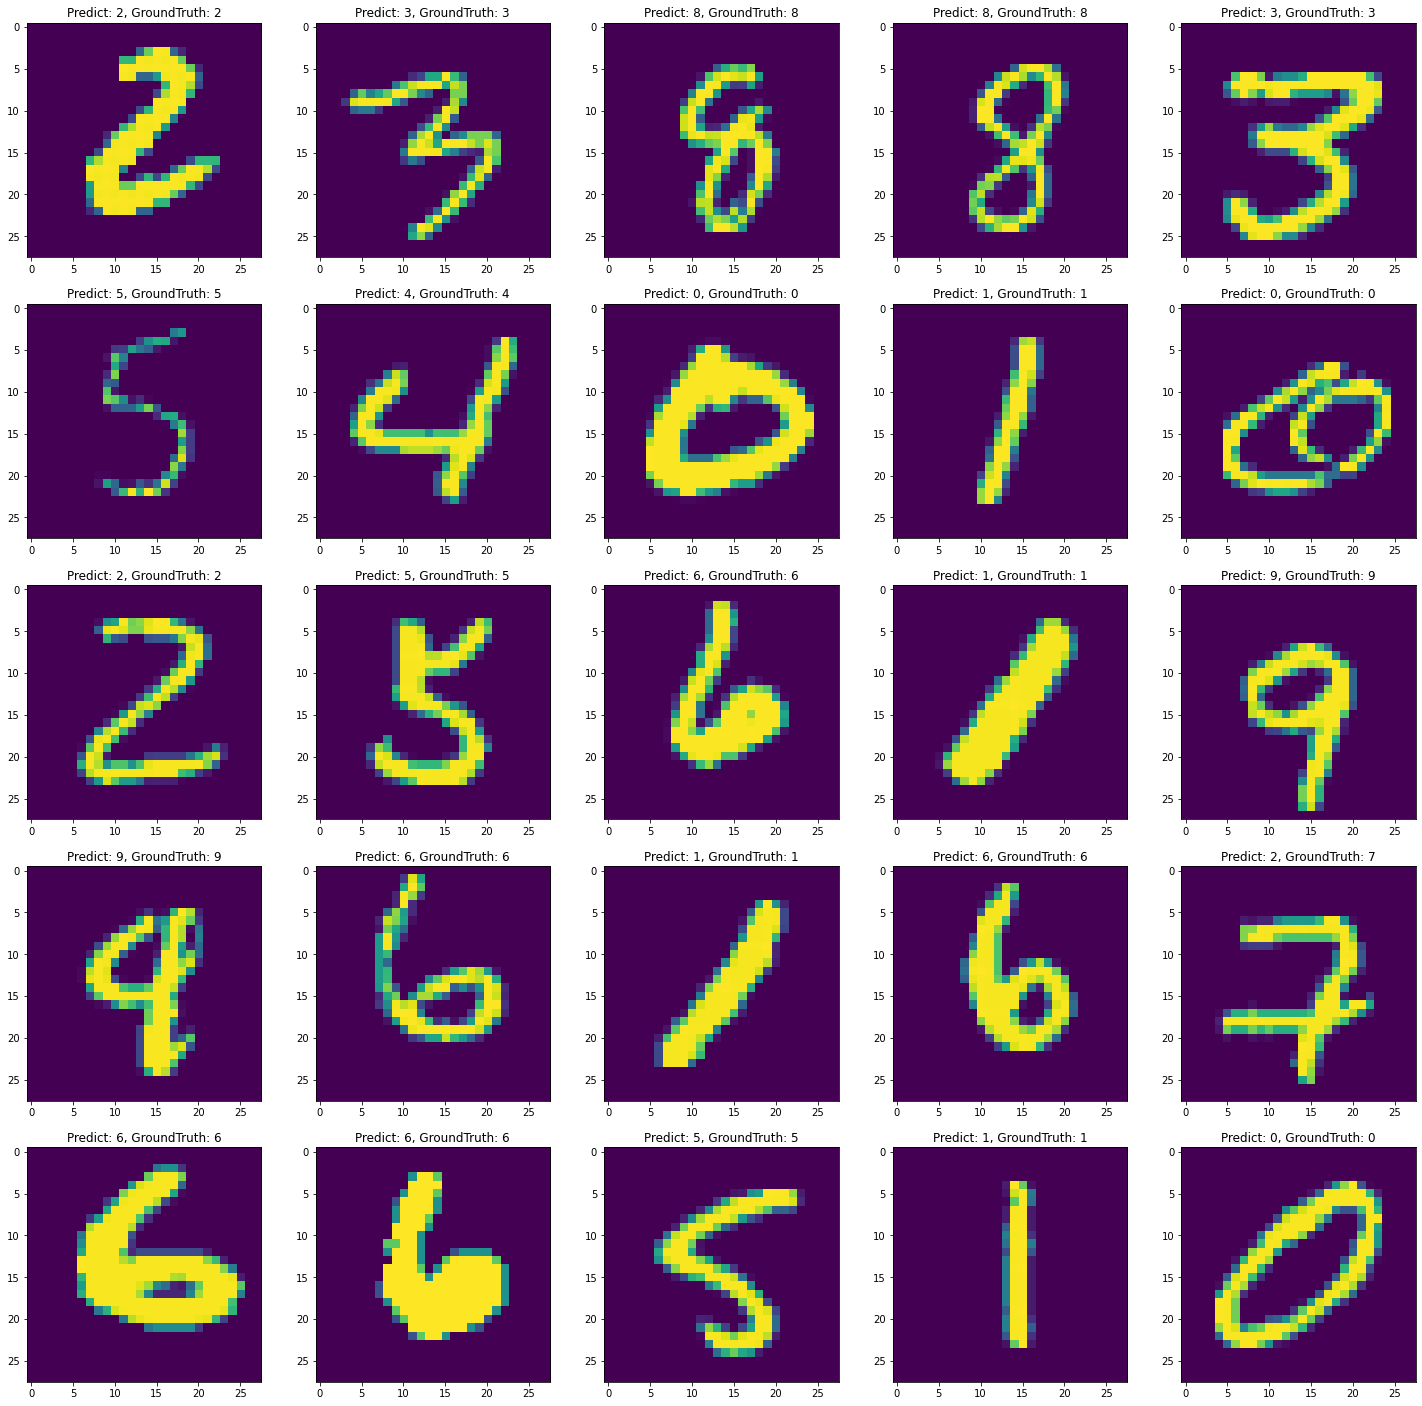

In [202]:
# 预测

network = load_model("model_0508")
show_rows = 5 # 五行
show_cols = 5 # 五列
select_count = show_rows * show_cols
select_iter = iter(test_loader)
test_batch_images, test_batch_labels, test_batch_onehots = next(select_iter)

predict        = network(norm_image(test_batch_images))  # 进行网络预测
predict_labels = predict.argmax(axis=1)  # 获取预测的标签值

plt.figure(figsize=(show_rows * 5, show_cols * 5))  # 定义画板的大小
for i in range(select_count):  # 显示图片和标题

    plt.subplot(show_rows, show_cols, i+1)

    predict_label      = predict_labels[i]
    ground_truth_label = test_batch_labels[i, 0]
    image              = test_batch_images[i].reshape(28, 28)

    plt.title(f"Predict: {predict_label}, GroundTruth: {ground_truth_label}")
    plt.imshow(image)